In [1]:
#Importing the necessary libarries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#Reading the data file with pandas library
df=pd.read_csv('perrin-freres-monthly-champagne-.csv')
df.columns=["Month","Sales"]
## Drop last 2 rows
df.drop(106,axis=0,inplace=True)
df.drop(105,axis=0,inplace=True)
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.head(5)

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [2]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


<AxesSubplot:xlabel='Month'>

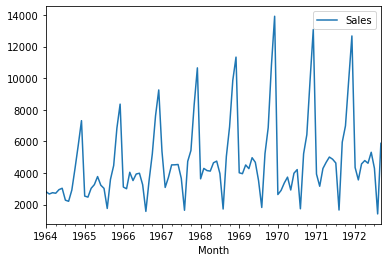

In [3]:
df.plot()

In [4]:
### Testing For Stationarity using Dicky fuller test

from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Sales'])
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(df['Sales'])


ADF Test Statistic : -1.8335930563276228
p-value : 0.363915771660245
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


# As the Data is non stationary, differencing method is used to make it stationary

In [5]:
#we shift the data with 12 which is one seasonal shift
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Month'>

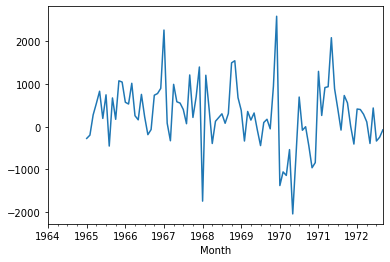

In [6]:
df['Seasonal First Difference'].plot()

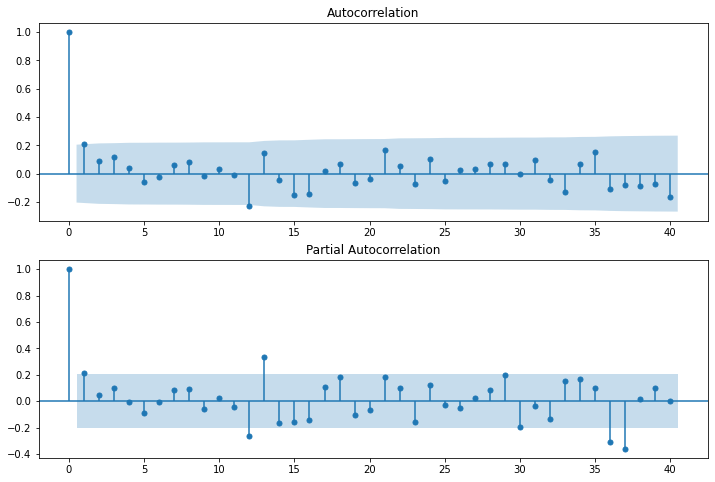

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

C:\Users\Comp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Comp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Month'>

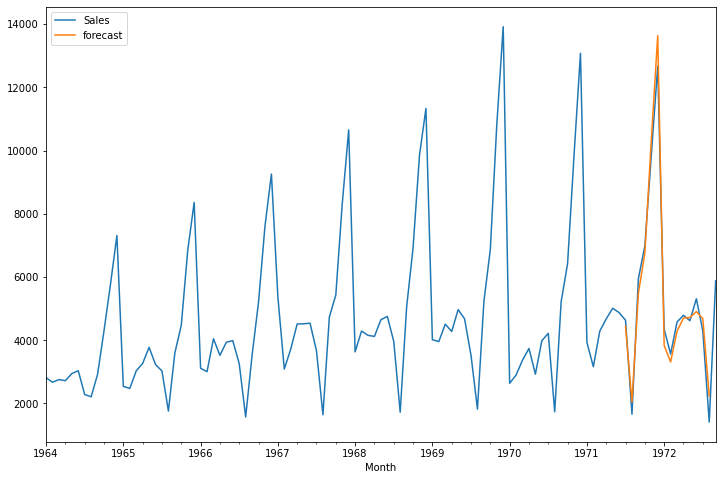

In [8]:
# For non-seasonal data the value of p, d, q  are interpreted by the ACF and PACF plots
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

<AxesSubplot:>

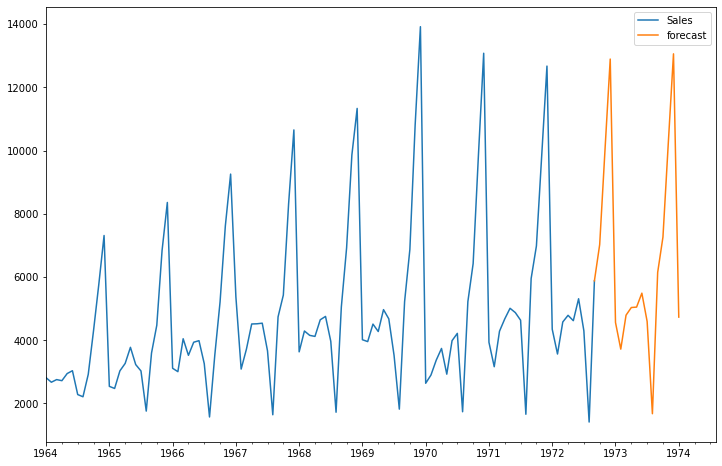

In [9]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df=pd.concat([df,future_datest_df])
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))

In [13]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Sat, 11 Dec 2021   AIC                           1486.804
Time:                                    23:49:51   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.61   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
rmse(df['Sales'].iloc[90:103], df['forecast'].iloc[90:103])

425.3321405293599

# Random Forest Regression model

In [15]:
#Reading the data file with pandas library
df=pd.read_csv('perrin-freres-monthly-champagne-.csv')
df.columns=["Month","Sales"]
df = df.drop('Month',axis=1)
df.drop(106,axis=0,inplace=True)
df.drop(105,axis=0,inplace=True)
df['Sale_LastMonth']=df['Sales'].shift(+1)
df['Sale_2Monthsback']=df['Sales'].shift(+2)
df['Sale_3Monthsback']=df['Sales'].shift(+3)
df=df.dropna()
import numpy as np
x1,x2,x3,y=df['Sale_LastMonth'],df['Sale_2Monthsback'],df['Sale_3Monthsback'],df['Sales']
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3),axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_x, y, test_size=0.10)


<ipython-input-16-2e7d67a978de>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


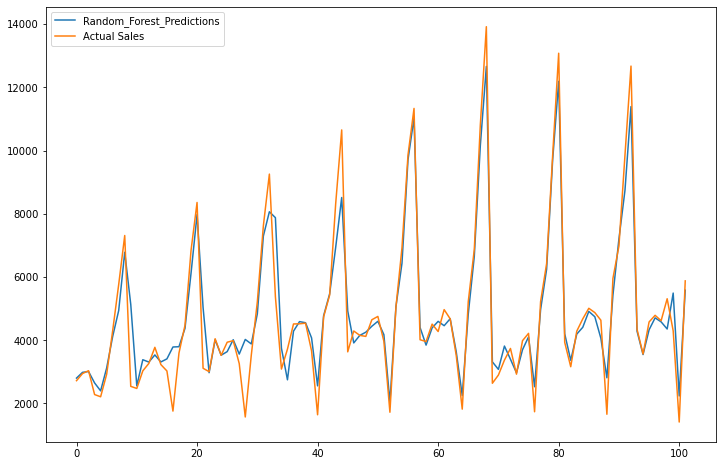

In [16]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=4)
model.fit(X_train, y_train)
pred=model.predict(final_x)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_rf=sqrt(mean_squared_error(pred,y))
print('Mean Squared Error for Random Forest Regression Model is:',rmse_rf)

Mean Squared Error for Random Forest Regression Model is: 740.7998077263862
